In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import statsmodels
import sklearn
import matplotlib
%matplotlib inline
from pylab import rcParams

In [2]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, month_plot
from statsmodels.distributions.empirical_distribution import ECDF
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt, ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings('ignore')
import itertools

# Basics + EDA

In [63]:
df = pd.read_csv('Sparkling.csv', parse_dates=['YearMonth'], index_col=['YearMonth'])

In [64]:
df.head()

,Sparkling
YearMonth,
1980-01-01,1686
1980-02-01,1591
1980-03-01,2304
1980-04-01,1712
1980-05-01,1471


In [68]:
df = df.rename_axis('Date')
df = df.rename(columns={'Sparkling': 'Sales'})

## Visualizing Raw Data

In [8]:
df.describe().T.round()

,count,mean,std,min,25%,50%,75%,max
Sales,187.0,2402.0,1295.0,1070.0,1605.0,1874.0,2549.0,7242.0


In [328]:
sns.set_style('white')

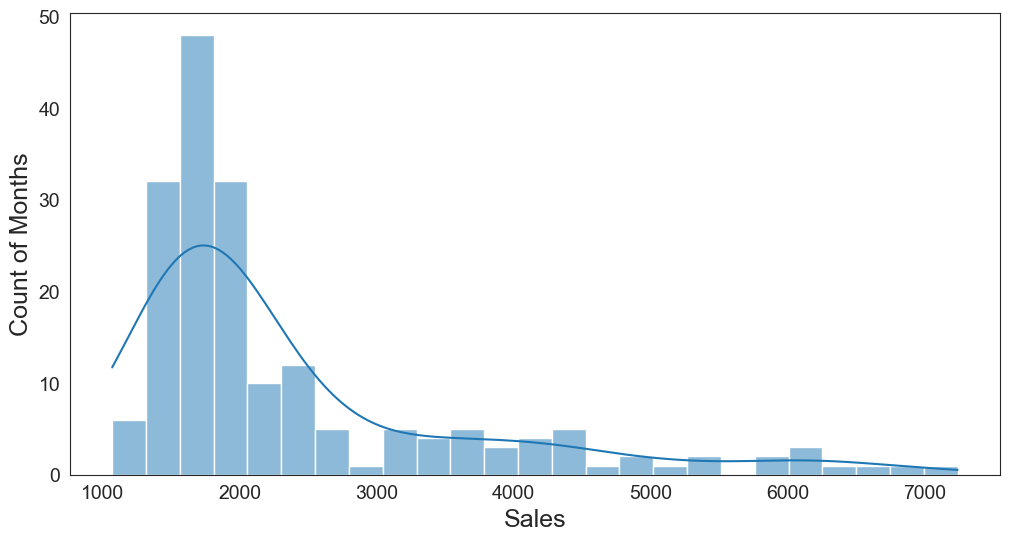

In [339]:
sns.histplot(df['Sales'], kde=True, binwidth=250);
plt.xticks(fontsize=14);
plt.yticks(fontsize=14);
plt.xlabel('Sales', fontsize=18)
plt.ylabel('Count of Months',fontsize=18);

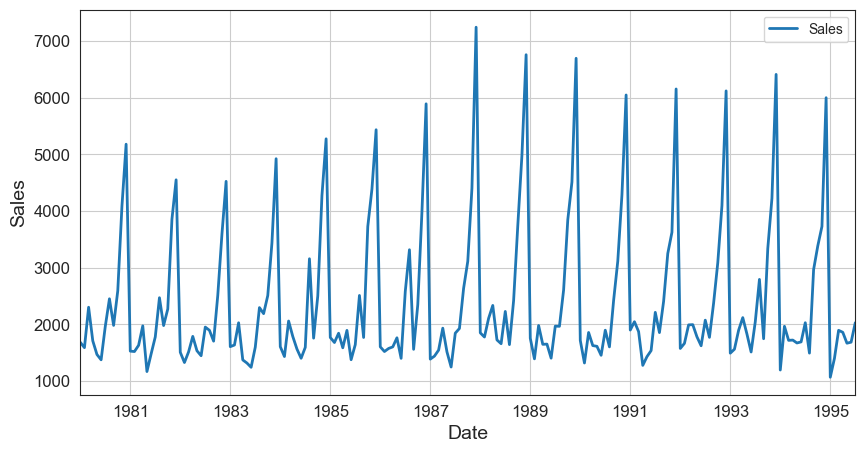

In [344]:
rcParams['figure.figsize'] = 10, 5
df.plot(linewidth=2)
plt.xticks(fontsize=12);
plt.yticks(fontsize=12);
plt.xlabel('Date', fontsize=14)
plt.ylabel('Sales', fontsize=14)
plt.grid()

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 187 entries, 1980-01-01 to 1995-07-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Sales   187 non-null    int64
dtypes: int64(1)
memory usage: 2.9 KB


In [15]:
df.isnull().sum()

Sales    0
dtype: int64

## Boxplots

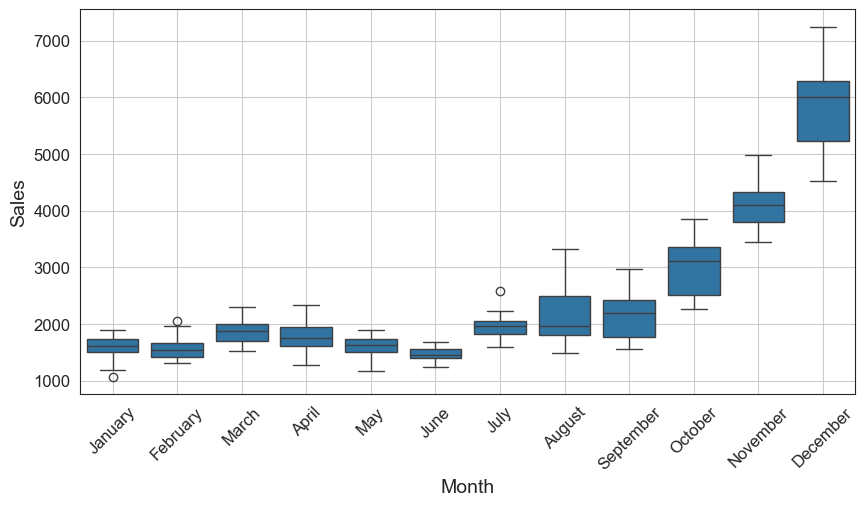

In [391]:
rcParams['figure.figsize'] = 10, 5
ax = sns.boxplot(x = df.index.month_name(), y = df['Sales'])
# ax.set_xticklabels(df.index.month_name(),rotation=45, fontsize=12);
ax.tick_params(axis='x', labelsize=12, labelrotation=45)
ax.tick_params(axis='y', labelsize=12)
plt.grid()
ax.set_xlabel('Month', fontsize=14)
ax.set_ylabel('Sales', fontsize=14)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


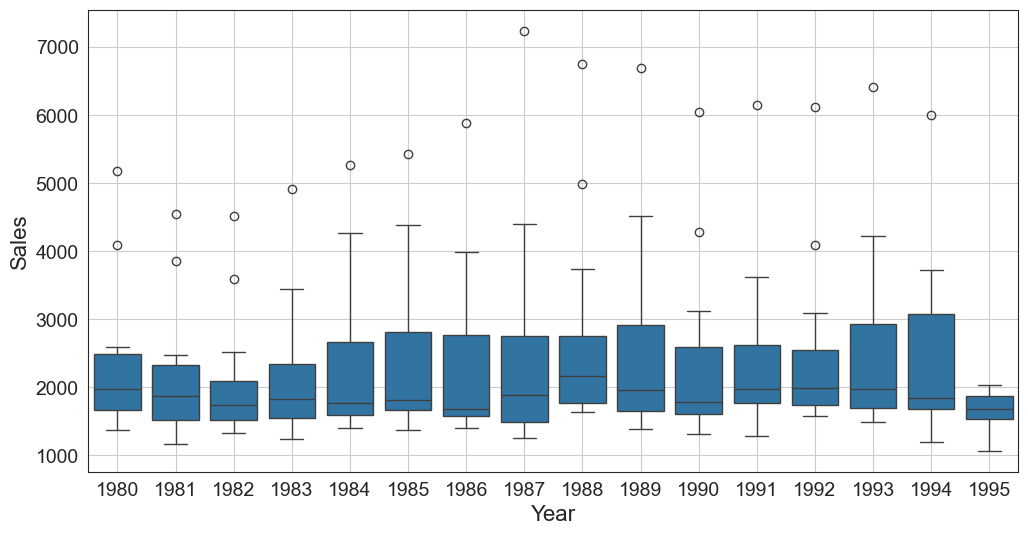

In [393]:
rcParams['figure.figsize'] = 12, 6
ax = sns.boxplot(x = df.index.year, y = df['Sales'])
# ax.set_xticklabels(df.index.year,rotation=45)
# ax.set_xticklabels(df.index.month_name(),rotation=45);
ax.tick_params(labelsize=14)
ax.set_xlabel('Year', fontsize=16)
ax.set_ylabel('Sales', fontsize=16)
ax.legend().set_visible(False)
plt.grid()
plt.show()

## Pivot Table

In [394]:
monthly_sales = pd.pivot_table(df, columns=df.index.month_name(), index = df.index.year, values='Sales', aggfunc='sum')

In [395]:
monthly_sales = monthly_sales.reindex(columns = ['January', 'February', 'March', 'April', 
                                                 'May', 'June', 'July', 'August', 'September', 
                                                 'October', 'November', 'December'])

In [396]:
monthly_sales = monthly_sales.rename_axis(columns='Month', index='Year')

In [397]:
monthly_sales.round()

Month,January,February,March,April,May,June,July,August,September,October,November,December
Year,,,,,,,,,,,,
1980,1686.0,1591.0,2304.0,1712.0,1471.0,1377.0,1966.0,2453.0,1984.0,2596.0,4087.0,5179.0
1981,1530.0,1523.0,1633.0,1976.0,1170.0,1480.0,1781.0,2472.0,1981.0,2273.0,3857.0,4551.0
1982,1510.0,1329.0,1518.0,1790.0,1537.0,1449.0,1954.0,1897.0,1706.0,2514.0,3593.0,4524.0
1983,1609.0,1638.0,2030.0,1375.0,1320.0,1245.0,1600.0,2298.0,2191.0,2511.0,3440.0,4923.0
1984,1609.0,1435.0,2061.0,1789.0,1567.0,1404.0,1597.0,3159.0,1759.0,2504.0,4273.0,5274.0
1985,1771.0,1682.0,1846.0,1589.0,1896.0,1379.0,1645.0,2512.0,1771.0,3727.0,4388.0,5434.0
1986,1606.0,1523.0,1577.0,1605.0,1765.0,1403.0,2584.0,3318.0,1562.0,2349.0,3987.0,5891.0
1987,1389.0,1442.0,1548.0,1935.0,1518.0,1250.0,1847.0,1930.0,2638.0,3114.0,4405.0,7242.0
1988,1853.0,1779.0,2108.0,2336.0,1728.0,1661.0,2230.0,1645.0,2421.0,3740.0,4988.0,6757.0


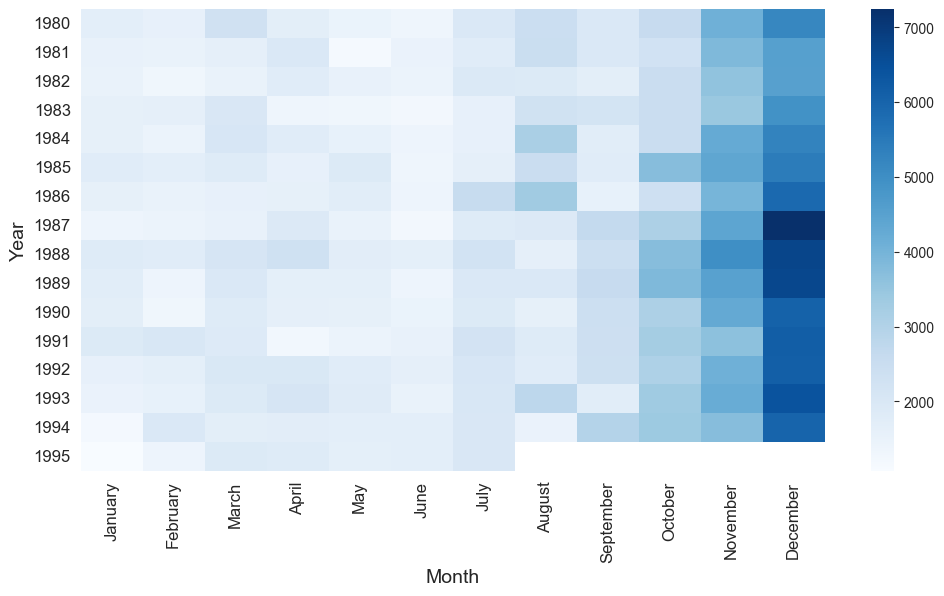

In [411]:
sns.heatmap(monthly_sales, cmap='Blues');
plt.xlabel('Month', fontsize=14)
plt.ylabel('Year', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12);

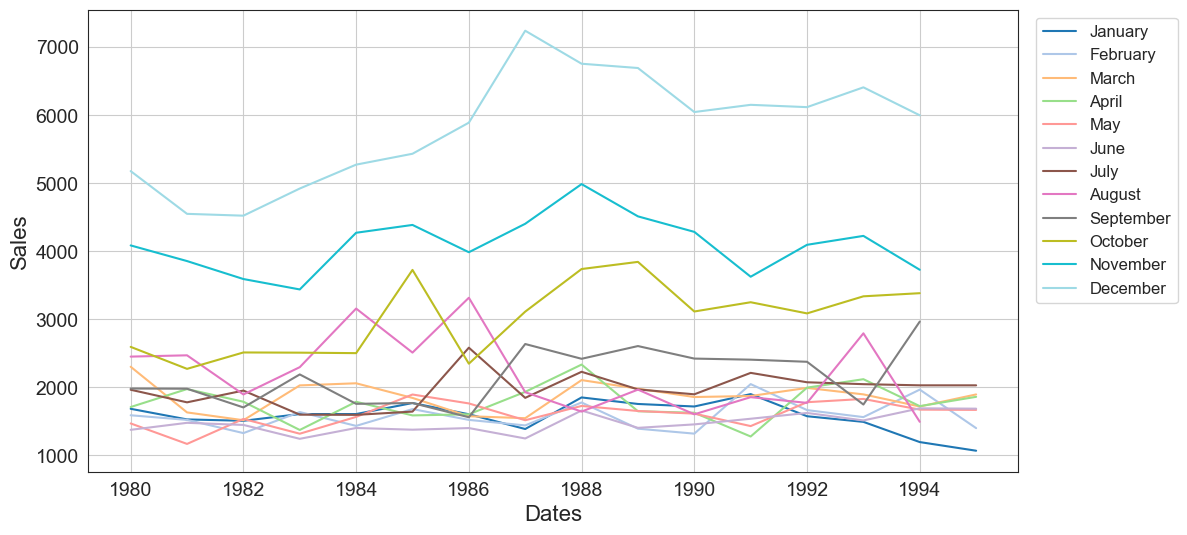

In [412]:
monthly_sales.plot(colormap='tab20');
plt.grid()
plt.xlabel('Dates', fontsize=16)
plt.ylabel('Sales', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc=2 , fontsize=12, bbox_to_anchor=(1.01,1));

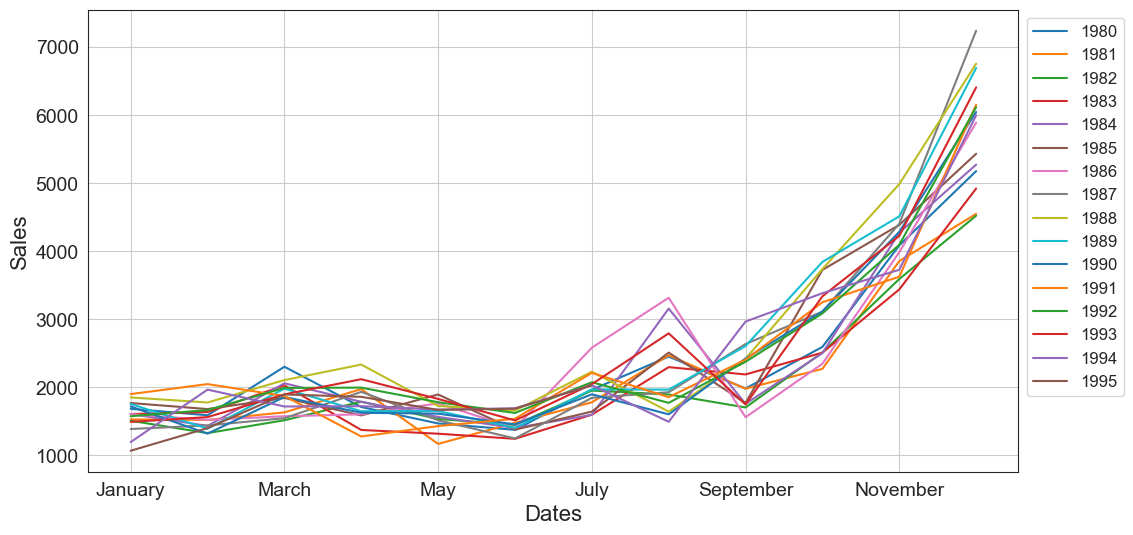

In [413]:
monthly_sales.T.plot()
plt.grid()
plt.xlabel('Dates', fontsize=16)
plt.ylabel('Sales', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc=2 , fontsize=12, bbox_to_anchor=(1,1));
plt.show()

## Other Plots

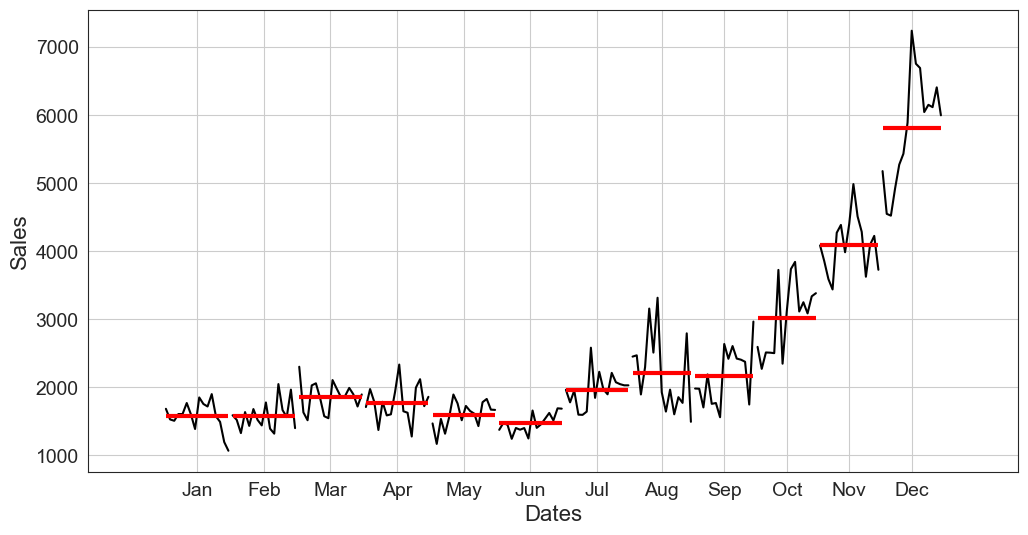

In [409]:
month_plot(df, ylabel='Sales')
plt.xlabel('Dates', fontsize=16)
plt.ylabel('Sales', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid()

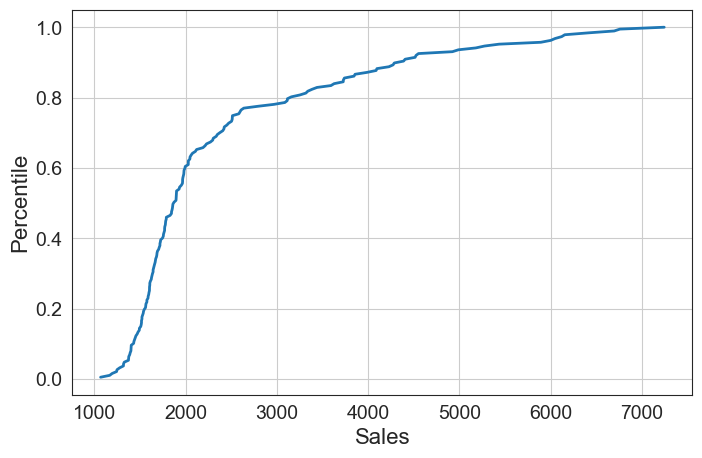

In [419]:
plt.figure(figsize=(8, 5))
cdf = ECDF(df['Sales'])
plt.plot(cdf.x, cdf.y, label='Sales', linewidth=2)
plt.xlabel('Sales', fontsize=16)
plt.ylabel('Percentile', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid()
plt.show();

In [52]:
pct_change = df.groupby(df.index.year)['Sales'].pct_change()

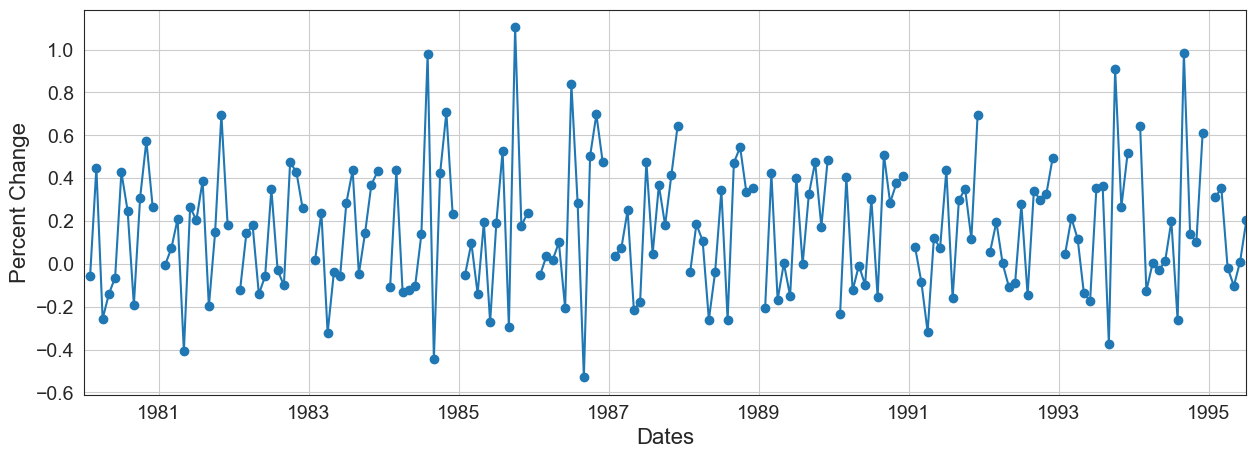

In [420]:
rcParams['figure.figsize'] = 15, 5
pct_change.plot(marker='o', grid=True)
plt.xlabel('Dates', fontsize=16)
plt.ylabel('Percent Change', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

## Decompose

### Additive

In [54]:
decomp_add = seasonal_decompose(df, model='additive')

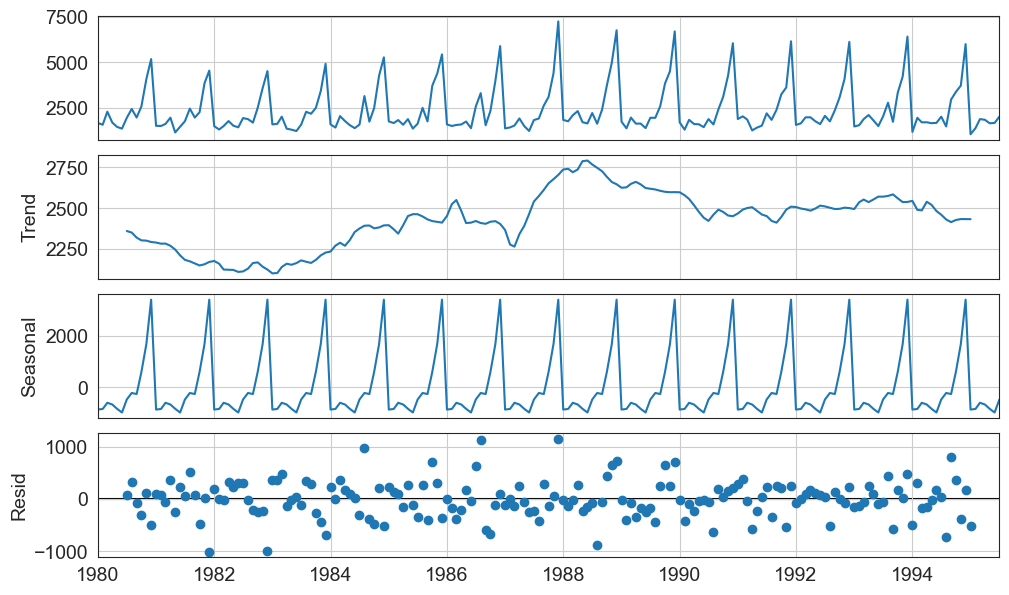

In [427]:
rcParams['figure.figsize'] = 10,6
fig = decomp_add.plot();
for ax in fig.axes:
    ax.tick_params(axis='x', which='major', labelsize=14)
    ax.tick_params(axis='y', labelsize=14)
    ax.tick_params(axis='both', which='minor', labelsize=12)
    ax.set_xlabel(ax.get_xlabel(), fontsize=14)
    ax.set_ylabel(ax.get_ylabel(), fontsize=14)
    ax.grid(True)

### Multiplicative

In [56]:
decomp_mul = seasonal_decompose(df, model='multiplicative')

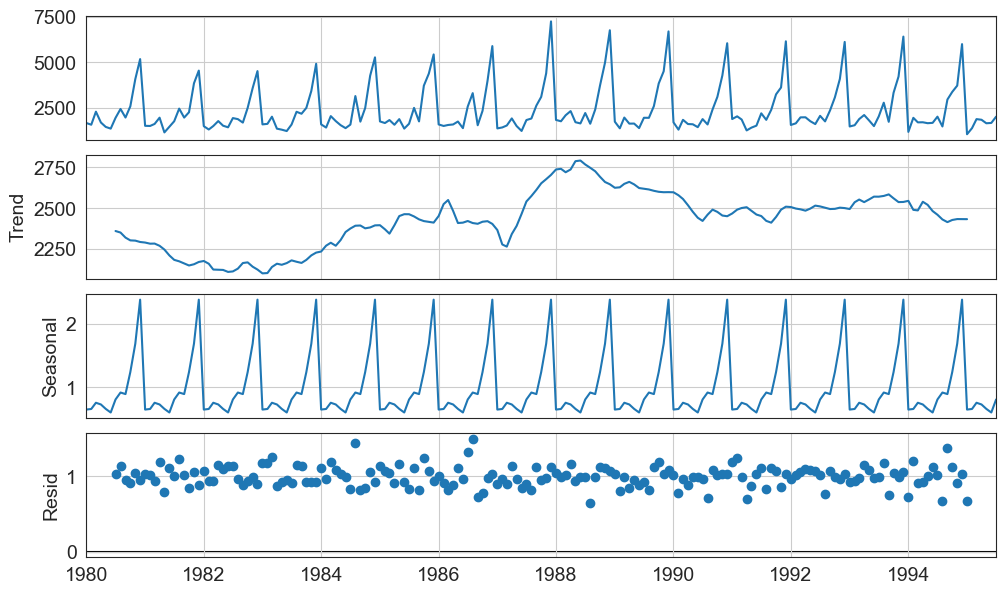

In [428]:
rcParams['figure.figsize'] = 10,6
fig = decomp_mul.plot();
for ax in fig.axes:
    ax.tick_params(axis='x', which='major', labelsize=14)
    ax.tick_params(axis='y', labelsize=14)
    ax.set_xlabel(ax.get_xlabel(), fontsize=14)
    ax.set_ylabel(ax.get_ylabel(), fontsize=14)
    ax.grid(True)

# Model Building - Original Data

## Train Test Split

In [69]:
train = df[0:int(len(df)*0.7)]
test = df[int(len(df)*0.7):]

In [70]:
print(train.shape)
print(test.shape)

(130, 1)
(57, 1)


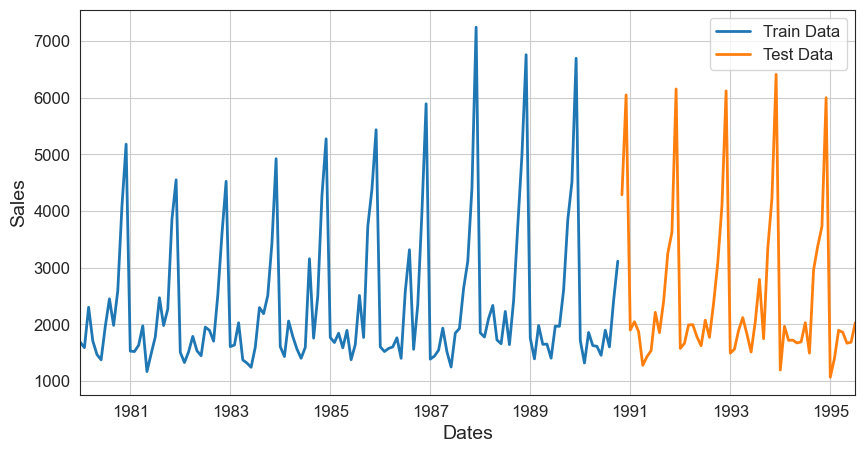

In [71]:
train['Sales'].plot(figsize=(10,5), linewidth=2)
test['Sales'].plot(figsize=(10,5), linewidth=2)
plt.grid()
plt.legend(['Train Data', 'Test Data'], fontsize=12)
plt.xlabel('Dates', fontsize=14)
plt.ylabel('Sales', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

## Linear Regression

In [72]:
train_time = [i+1 for i in range(len(train))]
test_time = [i+131 for i in range(len(test))]

In [73]:
print(train_time)
print(test_time)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130]
[131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187]


In [74]:
lr_train = train.copy()
lr_test = test.copy()

In [75]:
lr_train['time'] = train_time
lr_test['time'] = test_time

In [76]:
lr_train.head()

,Sales,time
Date,,
1980-01-01,1686,1
1980-02-01,1591,2
1980-03-01,2304,3
1980-04-01,1712,4
1980-05-01,1471,5


In [77]:
lr_test.head()

,Sales,time
Date,,
1990-11-01,4286,131
1990-12-01,6047,132
1991-01-01,1902,133
1991-02-01,2049,134
1991-03-01,1874,135


In [78]:
lr = LinearRegression()

In [79]:
lr.fit(lr_train[['time']], lr_train['Sales'])

LinearRegression()

In [80]:
lr_pred = lr.predict(lr_test[['time']])

In [81]:
lr_test['RegOutput'] = lr_pred

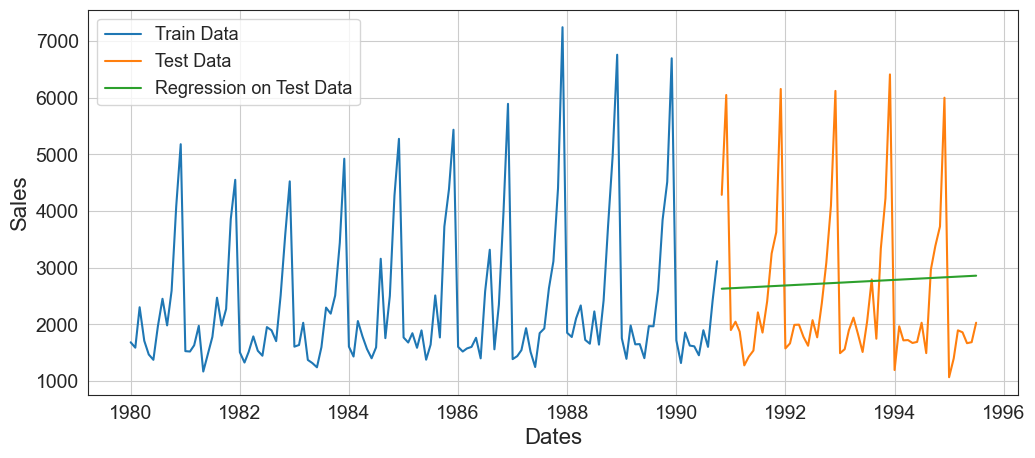

In [82]:
plt.figure(figsize=(12,5))
plt.plot(lr_train['Sales'], label='Train Data')
plt.plot(lr_test['Sales'], label='Test Data')
plt.plot(lr_test['RegOutput'], label='Regression on Test Data')
plt.grid()
plt.xlabel('Dates', fontsize=16)
plt.ylabel('Sales', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='best', fontsize=13)
plt.show()

In [83]:
lr_rmse = np.sqrt(metrics.mean_squared_error(lr_test['Sales'], lr_test['RegOutput']))

In [84]:
print(f'For Linear Regression on Test Data the RMSE is {lr_rmse:0.2f}')

For Linear Regression on Test Data the RMSE is 1392.44


In [85]:
resultsDF = pd.DataFrame(columns=['Model', 'Test RMSE'])

In [86]:
lr_row = pd.DataFrame({'Model': 'Linear Regression', 'Test RMSE': lr_rmse}, index=[0])

In [87]:
resultsDF = pd.concat([resultsDF, lr_row])

In [88]:
resultsDF

,Model,Test RMSE
0,Linear Regression,1392.438305


## Moving Average

In [89]:
ma_df = df.copy()

### Trailing Moving Averages

In [90]:
ma_df['tr_2'] = ma_df['Sales'].rolling(window=2).mean()
ma_df['tr_6'] = ma_df['Sales'].rolling(window=6).mean()
ma_df['tr_9'] = ma_df['Sales'].rolling(window=9).mean()

In [91]:
ma_df.head()

,Sales,tr_2,tr_6,tr_9
Date,,,,
1980-01-01,1686,NaN,NaN,NaN
1980-02-01,1591,1638.5,NaN,NaN
1980-03-01,2304,1947.5,NaN,NaN
1980-04-01,1712,2008.0,NaN,NaN
1980-05-01,1471,1591.5,NaN,NaN


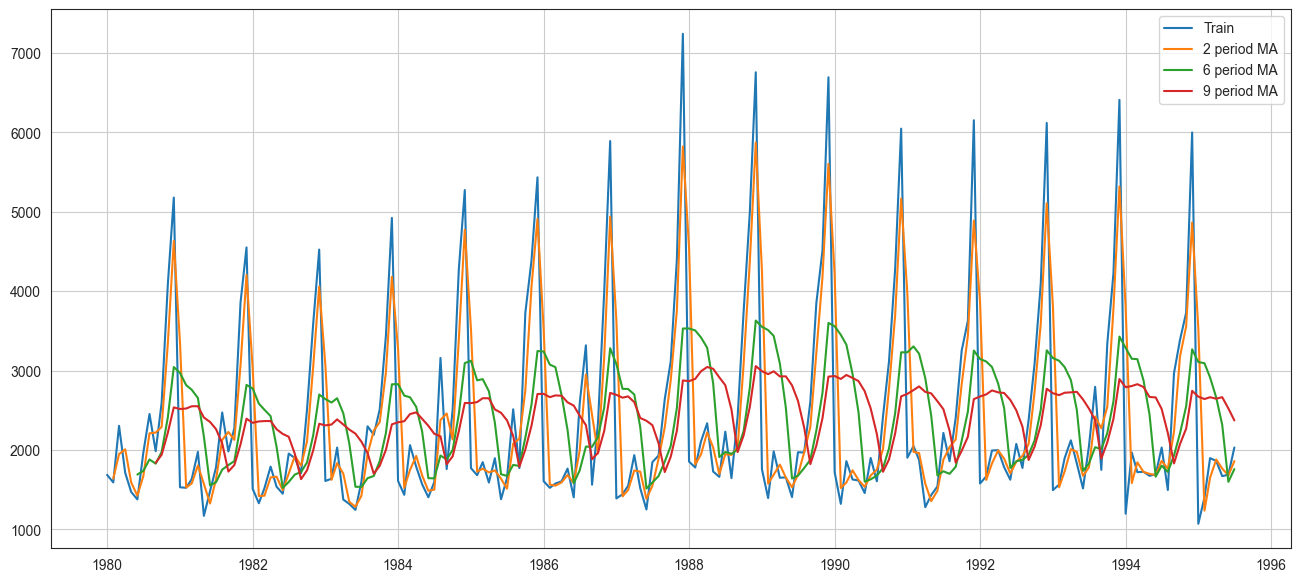

In [92]:
plt.figure(figsize=(16,7))
plt.plot(ma_df['Sales'], label='Train')
plt.plot(ma_df['tr_2'], label='2 period MA')
plt.plot(ma_df['tr_6'], label='6 period MA')
plt.plot(ma_df['tr_9'], label='9 period MA')
plt.grid()
plt.legend(loc='best')
plt.show();

In [93]:
tr_ma_train = ma_df[0:int(len(ma_df)*0.7)]
tr_ma_test = ma_df[int(len(ma_df)*0.7):]

In [94]:
tr_ma_test['pred_tr2'] = tr_ma_train['tr_2'].iloc[-1]
tr_ma_test['pred_tr6'] = tr_ma_train['tr_6'].iloc[-1]
tr_ma_test['pred_tr9'] = tr_ma_train['tr_9'].iloc[-1]

In [95]:
tr_ma_test.head().round()

,Sales,tr_2,tr_6,tr_9,pred_tr2,pred_tr6,pred_tr9
Date,,,,,,,
1990-11-01,4286,3701.0,2464.0,2210.0,2770.0,2019.0,1880.0
1990-12-01,6047,5166.0,3230.0,2675.0,2770.0,2019.0,1880.0
1991-01-01,1902,3974.0,3230.0,2706.0,2770.0,2019.0,1880.0
1991-02-01,2049,1976.0,3304.0,2754.0,2770.0,2019.0,1880.0
1991-03-01,1874,1962.0,3212.0,2800.0,2770.0,2019.0,1880.0


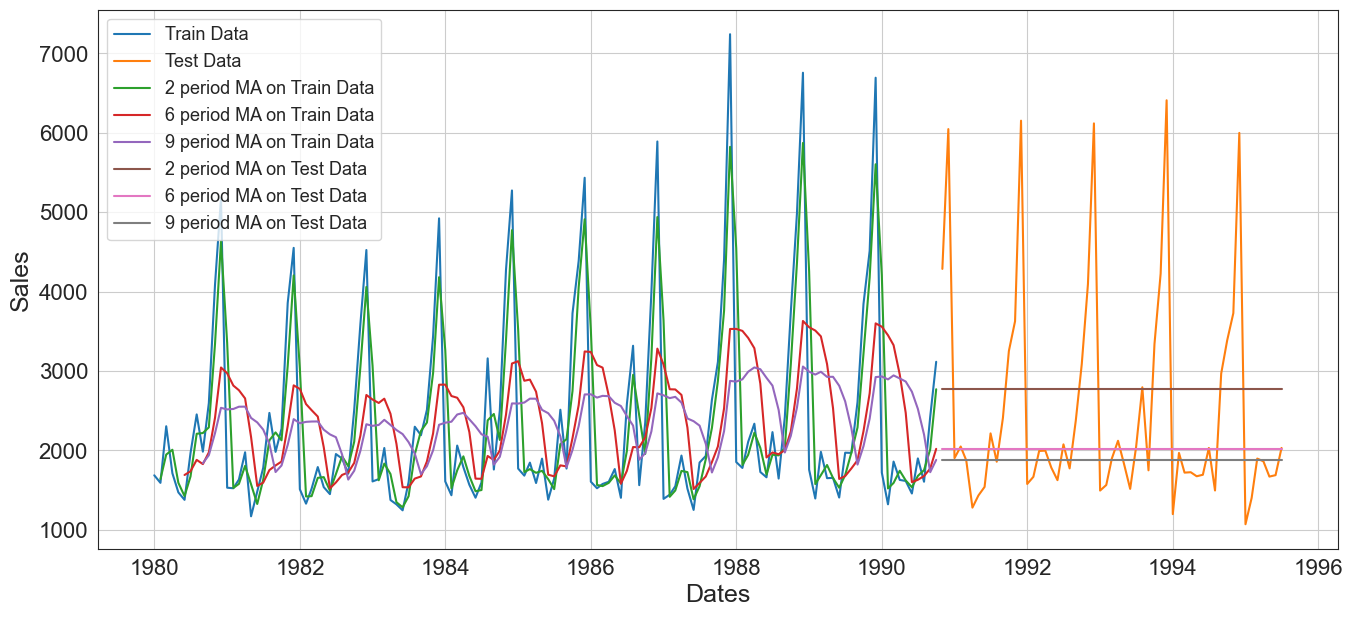

In [96]:
plt.figure(figsize=(16,7))
plt.plot(tr_ma_train['Sales'], label='Train Data')
plt.plot(tr_ma_test['Sales'], label='Test Data')

plt.plot(tr_ma_train['tr_2'], label='2 period MA on Train Data')
plt.plot(tr_ma_train['tr_6'], label='6 period MA on Train Data')
plt.plot(tr_ma_train['tr_9'], label='9 period MA on Train Data')

plt.plot(tr_ma_test['pred_tr2'], label='2 period MA on Test Data')
plt.plot(tr_ma_test['pred_tr6'], label='6 period MA on Test Data')
plt.plot(tr_ma_test['pred_tr9'], label='9 period MA on Test Data')

plt.xlabel('Dates', fontsize=18)
plt.ylabel('Sales', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(loc='best', fontsize=13)
plt.grid()

In [97]:
ma_rmse_tr2 = np.sqrt(metrics.mean_squared_error(tr_ma_test['Sales'], tr_ma_test['pred_tr2']))
ma_rmse_tr6 = np.sqrt(metrics.mean_squared_error(tr_ma_test['Sales'], tr_ma_test['pred_tr6']))
ma_rmse_tr9 = np.sqrt(metrics.mean_squared_error(tr_ma_test['Sales'], tr_ma_test['pred_tr9']))

In [98]:
print(f'For 2 point MA the RMSE is {ma_rmse_tr2:0.2f}')
print(f'For 6 point MA the RMSE is {ma_rmse_tr6:0.2f}')
print(f'For 9 point MA the RMSE is {ma_rmse_tr9:0.2f}')

For 2 point MA the RMSE is 1389.31
For 6 point MA the RMSE is 1443.15
For 9 point MA the RMSE is 1494.81


In [99]:
ma_temp_df = pd.DataFrame({'Model': ['2 point MA', '6 point MA', '9 point MA'],
                           'Test RMSE': [ma_rmse_tr2, ma_rmse_tr6, ma_rmse_tr9]})

In [100]:
resultsDF = pd.concat([resultsDF, ma_temp_df], ignore_index=True)

In [101]:
resultsDF.round(2)

,Model,Test RMSE
0,Linear Regression,1392.44
1,2 point MA,1389.31
2,6 point MA,1443.15
3,9 point MA,1494.81


## Simple Exponential Smoothing

In [102]:
SES_train = train.copy()
SES_test = test.copy()

In [103]:
model_SES =  SimpleExpSmoothing(SES_train['Sales'])

In [104]:
model_SES_autofit = model_SES.fit(optimized = True)

In [105]:
model_SES_autofit.params

{'smoothing_level': 0.037534299016257884,
 'smoothing_trend': nan,
 'smoothing_seasonal': nan,
 'damping_trend': nan,
 'initial_level': 1686.0,
 'initial_trend': nan,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [106]:
SES_test['SES_pred'] = model_SES_autofit.forecast(steps=len(test))

In [107]:
SES_test.head()

,Sales,SES_pred
Date,,
1990-11-01,4286,2465.235698
1990-12-01,6047,2465.235698
1991-01-01,1902,2465.235698
1991-02-01,2049,2465.235698
1991-03-01,1874,2465.235698


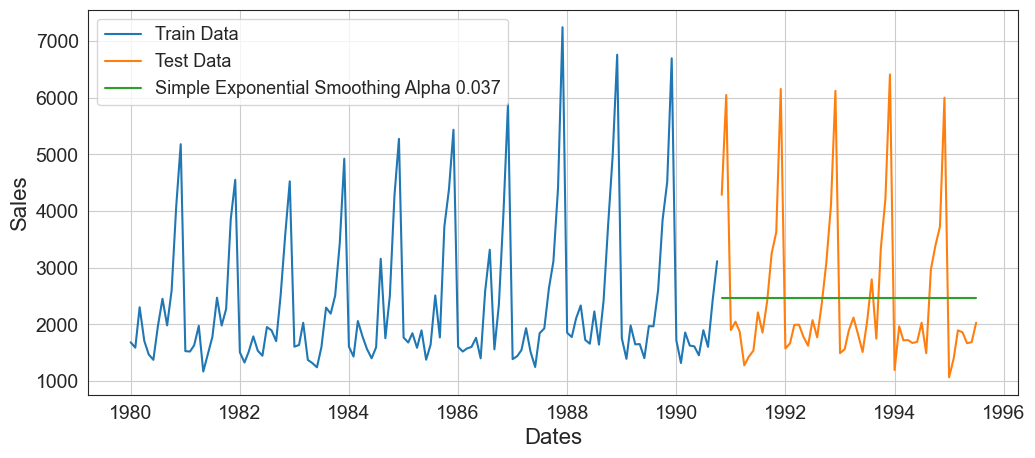

In [108]:
plt.figure(figsize=(12,5))
plt.plot(SES_train['Sales'], label='Train Data')
plt.plot(SES_test['Sales'], label='Test Data')
plt.plot(SES_test['SES_pred'], label='Simple Exponential Smoothing Alpha 0.037')

plt.xlabel('Dates', fontsize=16)
plt.ylabel('Sales', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='best', fontsize=13)
plt.grid()

In [109]:
rmse_ses_037 = np.sqrt(metrics.mean_squared_error(SES_test['Sales'], SES_test['SES_pred']))

In [110]:
print(f'For Simple Exponential Smoothing Alpha 0.037 the RMSE is {rmse_ses_037:0.2f}')

For Simple Exponential Smoothing Alpha 0.037 the RMSE is 1362.43


In [111]:
result_autoSES_037 = pd.DataFrame({'Model': 'Auto SES Alpha 0.037', 'Test RMSE': rmse_ses_037}, index=[0])

In [112]:
resultsDF = pd.concat([resultsDF, result_autoSES_037], ignore_index=True)

In [113]:
resultsDF.round(2)

,Model,Test RMSE
0,Linear Regression,1392.44
1,2 point MA,1389.31
2,6 point MA,1443.15
3,9 point MA,1494.81
4,Auto SES Alpha 0.037,1362.43


### Refining the SES Model

In [114]:
refine_SES_df = pd.DataFrame({'Alpha':[], 'Train RMSE':[], 'Test RMSE':[]})
refine_SES_df

,Alpha,Train RMSE,Test RMSE


In [115]:
for i in np.arange(0.1, 1.1, 0.1):
  model_SES_i =  model_SES.fit(smoothing_level=i, optimized=False, use_brute=True)
  SES_train['SES_pred',i] = model_SES_i.fittedvalues
  SES_test['SES_pred',i] = model_SES_i.forecast(steps=len(test))

  train_rmse = np.sqrt(metrics.mean_squared_error(SES_train['Sales'], SES_train['SES_pred',i]))
  test_rmse = np.sqrt(metrics.mean_squared_error(SES_test['Sales'], SES_test['SES_pred',i]))

  temp_df = pd.DataFrame({'Alpha': [i], 'Train RMSE': [train_rmse], 'Test RMSE': [test_rmse]})
  refine_SES_df = pd.concat([refine_SES_df, temp_df], ignore_index=True)

In [116]:
refine_SES_df.sort_values(by='Test RMSE')

,Alpha,Train RMSE,Test RMSE
3,0.4,1329.814823,1363.037803
4,0.5,1326.403864,1364.863549
0,0.1,1298.211536,1367.395642
2,0.3,1331.102204,1372.323705
1,0.2,1322.658289,1378.320562
5,0.6,1325.588422,1379.988733
6,0.7,1329.257530,1404.659104
7,0.8,1337.879425,1434.578214
8,0.9,1351.645478,1466.179706
9,1.0,1371.122286,1496.444629


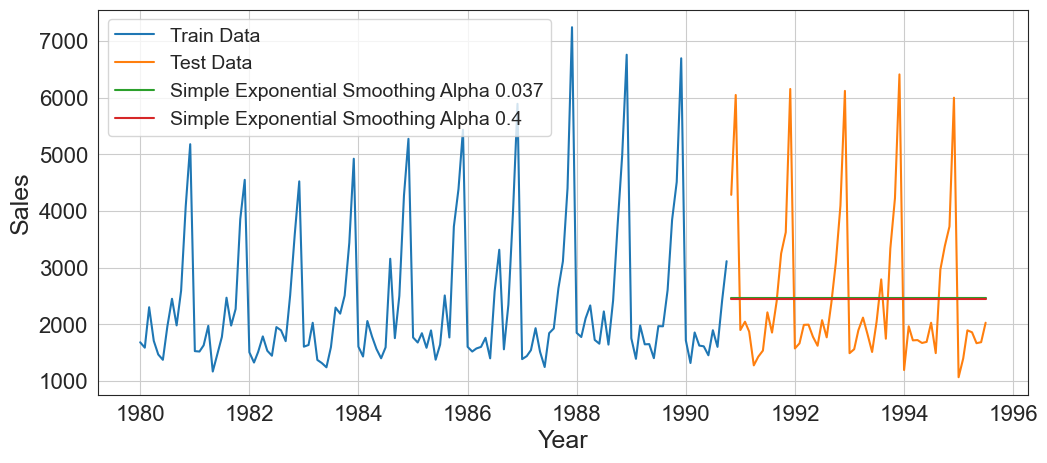

In [117]:
plt.figure(figsize=(12,5))
plt.plot(SES_train['Sales'], label='Train Data')
plt.plot(SES_test['Sales'], label='Test Data')
plt.plot(SES_test['SES_pred'], label='Simple Exponential Smoothing Alpha 0.037')
plt.plot(SES_test['SES_pred',0.4], label='Simple Exponential Smoothing Alpha 0.4')

plt.xlabel('Year', fontsize=18)
plt.ylabel('Sales', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(loc='best', fontsize=14)
plt.grid();

In [118]:
tempDF = pd.DataFrame({'Model': 'SES Refined Alpha 0.4',
                       'Test RMSE': refine_SES_df['Test RMSE'].sort_values(ascending=True).values[0]},  index=[0])

In [119]:
tempDF

,Model,Test RMSE
0,SES Refined Alpha 0.4,1363.037803


In [120]:
resultsDF = pd.concat([resultsDF, tempDF], ignore_index=True)

In [121]:
resultsDF

,Model,Test RMSE
0,Linear Regression,1392.438305
1,2 point MA,1389.313676
2,6 point MA,1443.154999
3,9 point MA,1494.811730
4,Auto SES Alpha 0.037,1362.428949
5,SES Refined Alpha 0.4,1363.037803


## Double Exponential Smoothing

In [122]:
DES_train = train.copy()
DES_test = test.copy()

In [123]:
model_DES = Holt(DES_train['Sales'])

In [124]:
results = []

In [125]:
for i in np.arange(0.1, 1.1, 0.1):
  for j in np.arange(0.1, 1.1, 0.1):
    model_DES_i_j = model_DES.fit(smoothing_level=i, smoothing_trend=j, optimized=False, use_brute=True)

    DES_train['DES_pred',i,j] = model_DES_i_j.fittedvalues
    DES_test['DES_pred',i,j] = model_DES_i_j.forecast(steps=len(test))

    rmse_DES_train = np.sqrt(metrics.mean_squared_error(DES_train['Sales'], DES_train['DES_pred',i,j]))
    rmse_DES_test = np.sqrt(metrics.mean_squared_error(DES_test['Sales'], DES_test['DES_pred',i,j]))

    results.append({'Alpha': i, 'Beta': j, 'Train RMSE': rmse_DES_train, 'Test RMSE': rmse_DES_test})

In [126]:
results_DF_DES = pd.DataFrame(results)

In [127]:
results_DF_DES.sort_values(by='Test RMSE')

,Alpha,Beta,Train RMSE,Test RMSE
30,0.4,0.1,1402.987160,1369.139116
21,0.3,0.2,1479.936342,1516.785129
15,0.2,0.6,1798.093767,1540.320476
40,0.5,0.1,1396.300778,1585.868237
22,0.3,0.3,1567.524066,1597.853999
...,...,...,...,...
69,0.7,1.0,1829.175506,26841.074837
79,0.8,1.0,1885.669827,27176.057077
27,0.3,0.8,1925.999079,29603.277989
29,0.3,1.0,1883.511575,33015.522624


In [128]:
tempDF = pd.DataFrame({'Model': 'DES Refined Alpha 0.4 Beta 0.1',
                       'Test RMSE': results_DF_DES['Test RMSE'].sort_values(ascending=True).values[0]},  index=[0])

In [129]:
tempDF

,Model,Test RMSE
0,DES Refined Alpha 0.4 Beta 0.1,1369.139116


In [130]:
resultsDF = pd.concat([resultsDF, tempDF], ignore_index=True)

In [131]:
resultsDF

,Model,Test RMSE
0,Linear Regression,1392.438305
1,2 point MA,1389.313676
2,6 point MA,1443.154999
3,9 point MA,1494.811730
4,Auto SES Alpha 0.037,1362.428949
5,SES Refined Alpha 0.4,1363.037803
6,DES Refined Alpha 0.4 Beta 0.1,1369.139116


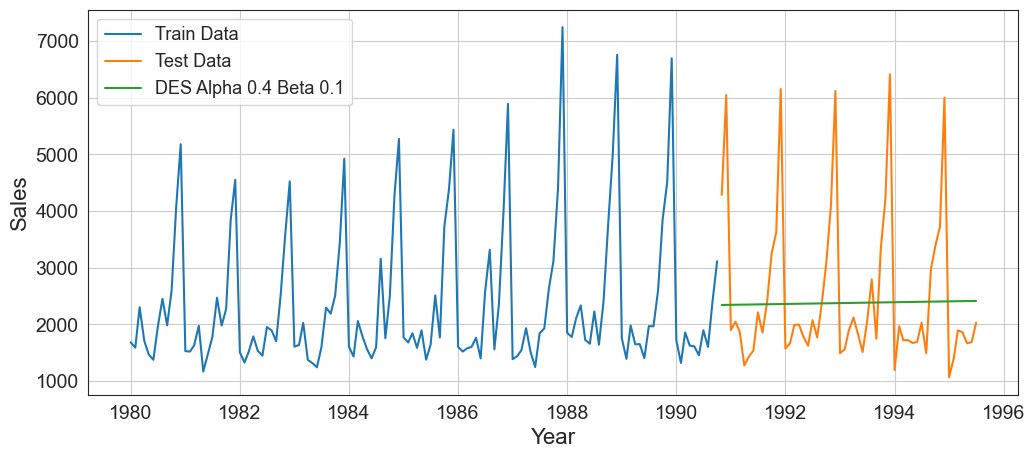

In [257]:
plt.figure(figsize=(12,5))
plt.plot(DES_train['Sales'], label='Train Data')
plt.plot(DES_test['Sales'], label='Test Data')

plt.plot(DES_test['DES_pred',0.4,0.1], label='DES Alpha 0.4 Beta 0.1')

plt.xlabel('Year', fontsize=16)
plt.ylabel('Sales', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='best', fontsize=13)
plt.grid()

## Triple Exponential Smoothing

### Auto TES

In [133]:
TES_train = train.copy()
TES_test = test.copy()

#### Checking Which Combination of Additive and Multiplicative Performs Best

In [146]:
results_check = []
options = ['add','mul']
TES_check_test = test.copy()

In [147]:
for i in options:
    for j in options:
        model_TES_check = ExponentialSmoothing(TES_train['Sales'], trend=i, seasonal=j, seasonal_periods=12)
        model_TES_check_fit = model_TES_check.fit(optimized=True)
        TES_check_test['predict'] = model_TES_check_fit.forecast(steps=len(test))
        rmse_TES_check = np.sqrt(metrics.mean_squared_error(TES_check_test['Sales'], TES_check_test['predict']))
        results_check.append({'Model': f'{i},{j}', 'RMSE': rmse_TES_check})

In [258]:
results_check_DF = pd.DataFrame(results_check)

In [260]:
results_check_DF

,Model,RMSE
0,"add,add",366.859156
1,"add,mul",381.657232
2,"mul,add",365.746152
3,"mul,mul",363.039954


#### Moving Ahead with Parameters based on Observation

In [261]:
model_TES = ExponentialSmoothing(TES_train['Sales'], trend='add', seasonal='add', seasonal_periods=12)

In [262]:
model_TES_autofit = model_TES.fit(optimized=True)

In [263]:
model_TES_autofit.params

{'smoothing_level': 0.07569306567652224,
 'smoothing_trend': 0.03243079353506148,
 'smoothing_seasonal': 0.4791359397032058,
 'damping_trend': nan,
 'initial_level': 2356.526392240251,
 'initial_trend': -0.7790750851036652,
 'initial_seasons': array([-636.24268489, -722.99133043, -398.63354546, -473.44405847,
        -808.44186274, -815.36460197, -384.23754735,   72.99614946,
        -237.45739424,  272.31927729, 1541.39485453, 2590.08852084]),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [264]:
TES_test['auto_predict'] = model_TES_autofit.forecast(steps=len(test))

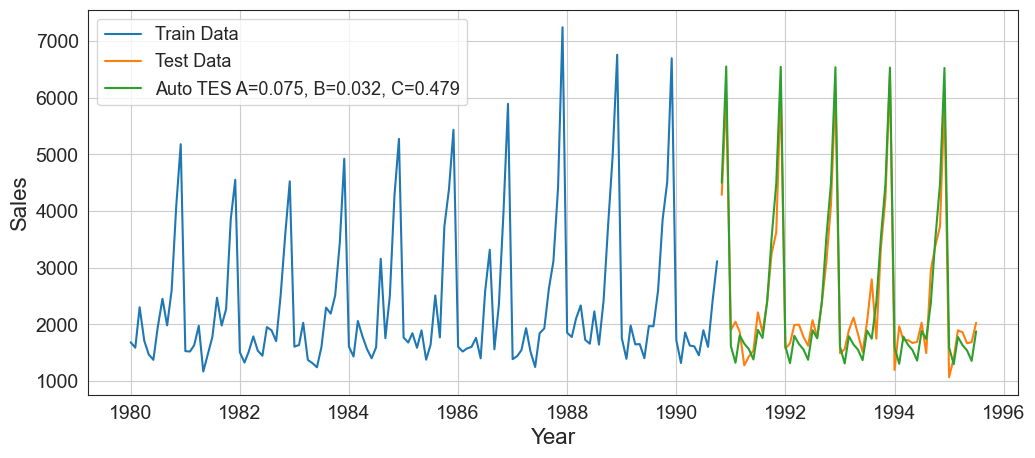

In [267]:
plt.figure(figsize=(12,5))
plt.plot(TES_train['Sales'], label='Train Data')
plt.plot(TES_test['Sales'], label='Test Data')
plt.plot(TES_test['auto_predict'], label='Auto TES A=0.075, B=0.032, C=0.479')

plt.xlabel('Year', fontsize=16)
plt.ylabel('Sales', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='best', fontsize=13)
plt.grid();

In [159]:
rmse_TES_auto = np.sqrt(metrics.mean_squared_error(TES_test['Sales'], TES_test['auto_predict']))

In [160]:
print(f'For Auto TES the RMSE is {rmse_TES_auto:0.2f}')

For Auto TES the RMSE is 366.86


In [161]:
tempDF = pd.DataFrame({'Model': 'TES Auto A=0.075, B=0.032, C=0.479', 'Test RMSE': rmse_TES_auto}, index=[0])

In [162]:
resultsDF = pd.concat([resultsDF, tempDF], ignore_index=True)

In [166]:
resultsDF

,Model,Test RMSE
0,Linear Regression,1392.438305
1,2 point MA,1389.313676
2,6 point MA,1443.154999
3,9 point MA,1494.811730
4,Auto SES Alpha 0.037,1362.428949
5,SES Refined Alpha 0.4,1363.037803
6,DES Refined Alpha 0.4 Beta 0.1,1369.139116
7,"TES Auto A=0.075, B=0.032, C=0.479",366.859156


### Refining TES

In [167]:
results_TES = []

In [168]:
for i in np.arange(0.1, 1.1, 0.1):
  for j in np.arange(0.1, 1.1, 0.1):
    for k in np.arange(0.1, 1.1, 0.1):
      model_TES_ijk = model_TES.fit(smoothing_level=i, smoothing_trend=j, smoothing_seasonal=k, optimized=False, use_brute=True)

      TES_train['TES_pred',i,j,k] = model_TES_ijk.fittedvalues
      TES_test['TES_pred',i,j,k] = model_TES_ijk.forecast(steps=len(test))

      rmse_TES_train = np.sqrt(metrics.mean_squared_error(TES_train['Sales'], TES_train['TES_pred',i,j,k]))
      rmse_TES_test = np.sqrt(metrics.mean_squared_error(TES_test['Sales'], TES_test['TES_pred',i,j,k]))

      results_TES.append({'Alpha': i, 'Beta': j, 'Gamma': k, 'Train RMSE': rmse_TES_train, 'Test RMSE': rmse_TES_test})

In [169]:
results_TES_df = pd.DataFrame(results_TES)

In [270]:
results_TES_df.sort_values(by='Test RMSE').round(2)

,Alpha,Beta,Gamma,Train RMSE,Test RMSE
84,0.1,0.9,0.5,437.48,353.28
93,0.1,1.0,0.4,437.15,378.55
600,0.7,0.1,0.1,494.13,381.17
801,0.9,0.1,0.2,501.50,399.94
410,0.5,0.2,0.1,493.54,405.09
...,...,...,...,...,...
988,1.0,0.9,0.9,355660.95,7597638.87
979,1.0,0.8,1.0,404701.27,8322372.88
989,1.0,0.9,1.0,1136914.67,26150971.98
998,1.0,1.0,0.9,1085896.81,26642032.99


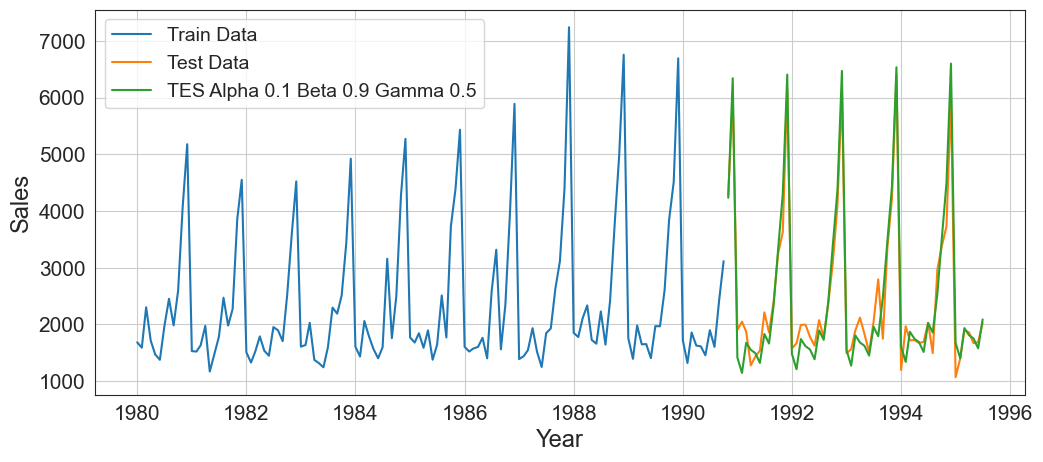

In [272]:
plt.figure(figsize=(12,5))
plt.plot(TES_train['Sales'], label='Train Data')
plt.plot(TES_test['Sales'], label='Test Data')

plt.plot(TES_test['TES_pred',0.1,0.9,0.5], label='TES Alpha 0.1 Beta 0.9 Gamma 0.5')

plt.xlabel('Year', fontsize=17)
plt.ylabel('Sales', fontsize=17)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(loc='best', fontsize=14)
plt.grid();

In [172]:
tempDF = pd.DataFrame({'Model': 'TES Refined Alpha 0.1 Beta 0.9 Gamma 0.5',
                       'Test RMSE': results_TES_df['Test RMSE'].sort_values(ascending=True).values[0]},  index=[0])

In [173]:
resultsDF = pd.concat([resultsDF, tempDF], ignore_index=True)

In [174]:
resultsDF

,Model,Test RMSE
0,Linear Regression,1392.438305
1,2 point MA,1389.313676
2,6 point MA,1443.154999
3,9 point MA,1494.811730
4,Auto SES Alpha 0.037,1362.428949
5,SES Refined Alpha 0.4,1363.037803
6,DES Refined Alpha 0.4 Beta 0.1,1369.139116
7,"TES Auto A=0.075, B=0.032, C=0.479",366.859156
8,TES Refined Alpha 0.1 Beta 0.9 Gamma 0.5,353.276441


## Plotting all 3 Together

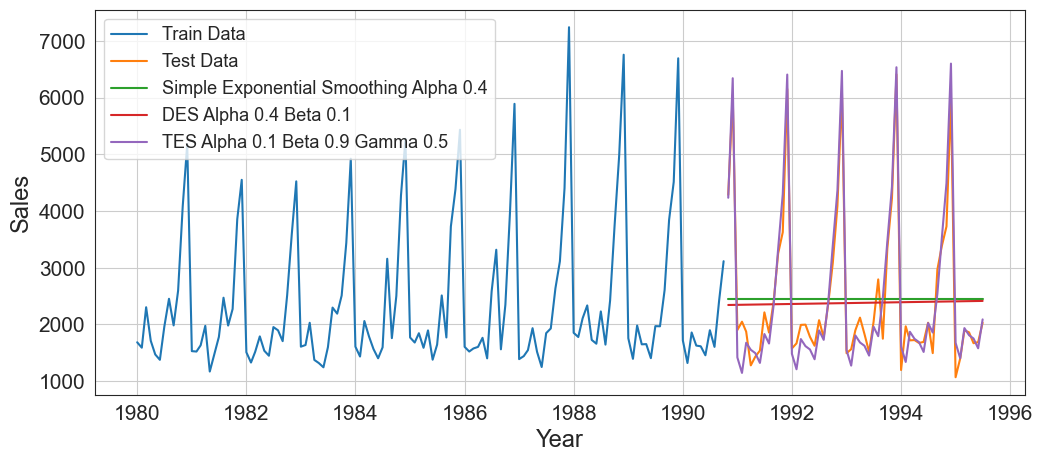

In [276]:
plt.figure(figsize=(12,5))
plt.plot(train['Sales'], label='Train Data')
plt.plot(test['Sales'], label='Test Data')

plt.plot(SES_test['SES_pred',0.4], label='Simple Exponential Smoothing Alpha 0.4')
plt.plot(DES_test['DES_pred',0.4,0.1], label='DES Alpha 0.4 Beta 0.1')
plt.plot(TES_test['TES_pred',0.1,0.9,0.5], label='TES Alpha 0.1 Beta 0.9 Gamma 0.5')

plt.xlabel('Year', fontsize=17)
plt.ylabel('Sales', fontsize=17)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(loc=2, fontsize=13)
plt.grid();

In [ ]:
resultsDF_orig = resultsDF.copy()

# Model Building - Stationary Data

## Check for Stationarity

In [176]:
check = adfuller(df['Sales'])

In [177]:
check

(-1.3604974548123367,
 0.6010608871634855,
 11,
 175,
 {'1%': -3.4682803641749267,
  '5%': -2.8782017240816327,
  '10%': -2.5756525795918366},
 2573.1222090270685)

In [178]:
print(f'The p-value is {check[1]:0.2f}')

The p-value is 0.60


In [278]:
rolmean = df['Sales'].rolling(window=6).mean()
rolstd = df['Sales'].rolling(window=6).std()

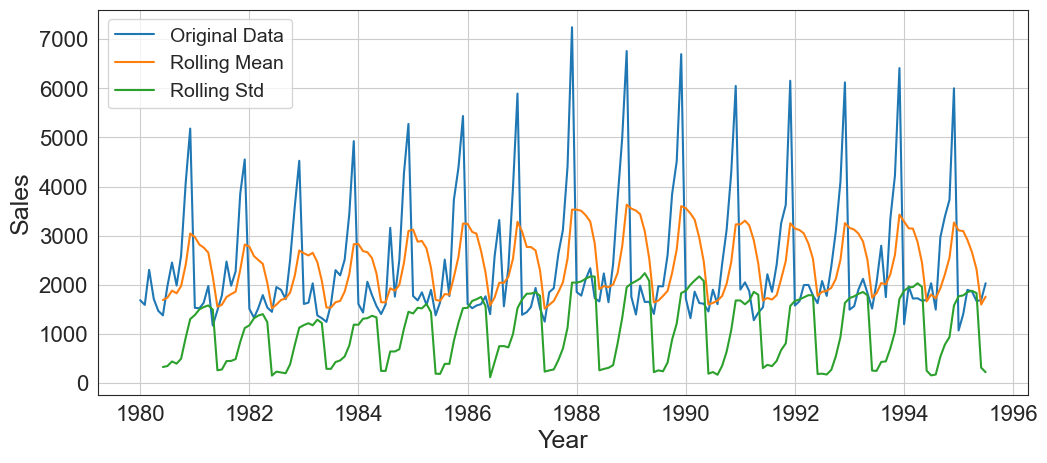

In [280]:
plt.figure(figsize=(12,5))
plt.plot(df['Sales'], label='Original Data')
plt.plot(rolmean, label='Rolling Mean')
plt.plot(rolstd, label='Rolling Std')
plt.grid()
plt.xlabel('Year', fontsize=18)
plt.ylabel('Sales', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(loc='best', fontsize=14)
plt.show();

In [181]:
train_Sales_diff = train['Sales'].diff().dropna()

In [182]:
check1 = adfuller(train_Sales_diff)

In [183]:
print(f'The p-value is {check1[1]:0.2f}')

The p-value is 0.00


In [184]:
rolmean = train_Sales_diff.rolling(window=6).mean()
rolstd = train_Sales_diff.rolling(window=6).std()

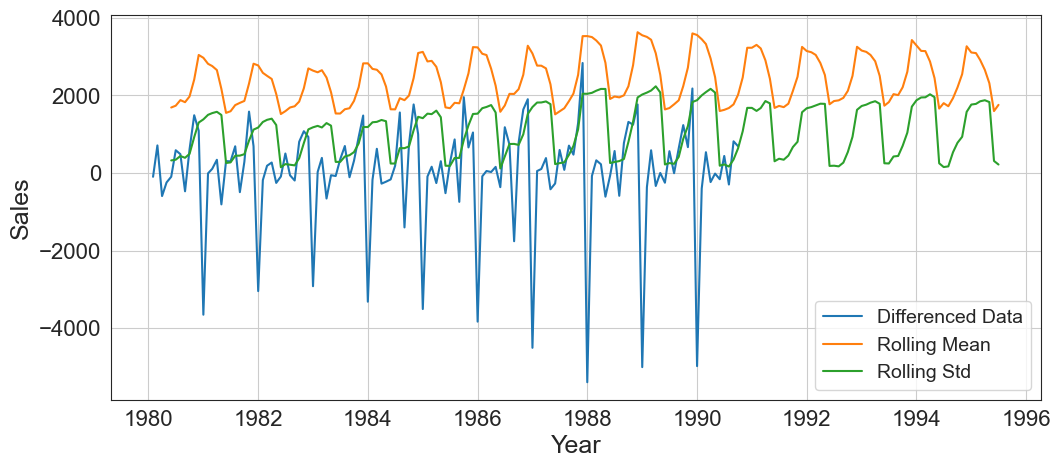

In [281]:
plt.figure(figsize=(12,5))
plt.plot(train_Sales_diff, label='Differenced Data')
plt.plot(rolmean, label='Rolling Mean')
plt.plot(rolstd, label='Rolling Std')
plt.grid()
plt.xlabel('Year', fontsize=18)
plt.ylabel('Sales', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(loc='best', fontsize=14)
plt.show();

## ACF & PACF Plots

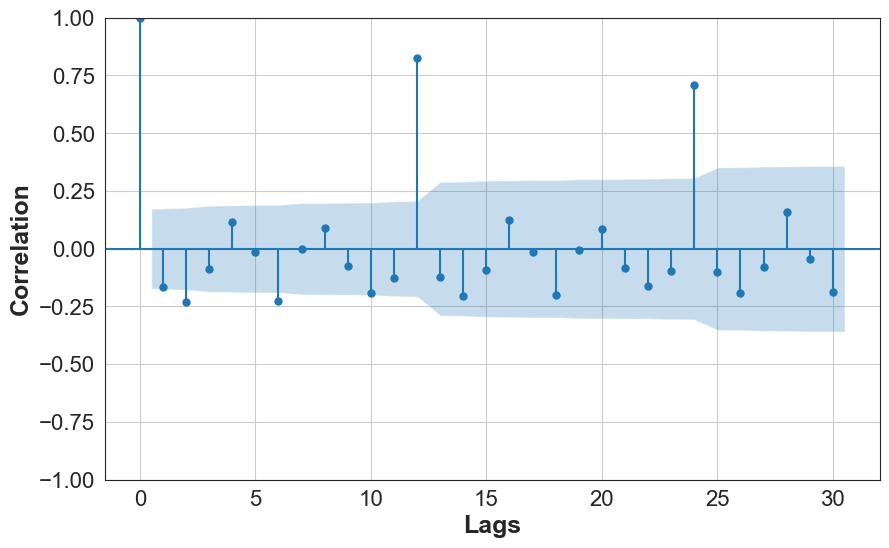

In [296]:
plot_acf(train_Sales_diff, lags=30);
plt.xlabel('Lags', fontsize=18, fontweight='bold')
plt.ylabel('Correlation', fontsize=18, fontweight='bold')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid()
plt.title(None);

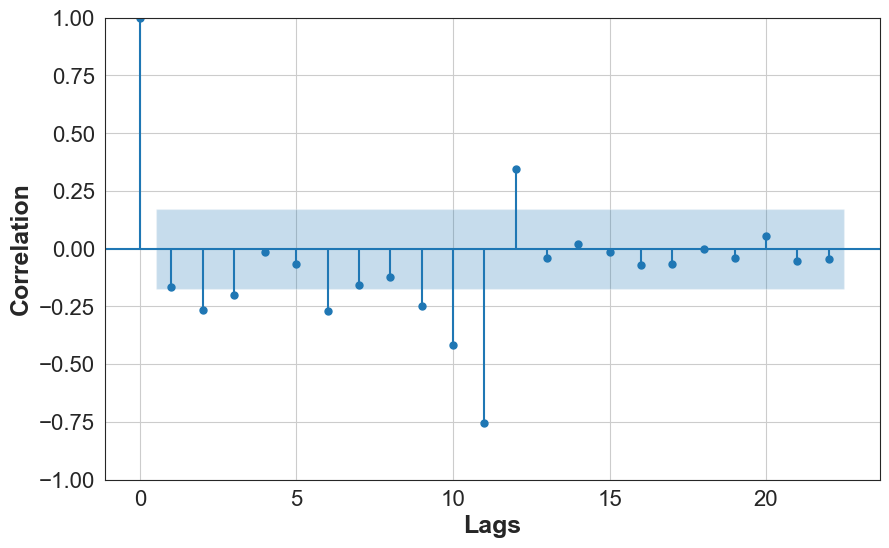

In [295]:
plot_pacf(train_Sales_diff);
plt.xlabel('Lags', fontsize=18, fontweight='bold')
plt.ylabel('Correlation', fontsize=18, fontweight='bold')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid()
plt.title(None);

## ARIMA Model

### Selecting Parameters based on AIC

In [188]:
p = q = range(0,3)
d = range(0,2)
pdq = list(itertools.product(p,d,q))

In [189]:
ARIMA_AIC = []

In [190]:
for param in pdq:
    model_ARIMA = ARIMA(train_Sales_diff.values, order=param).fit()
    ARIMA_AIC.append({'param':param, 'AIC': model_ARIMA.aic})

In [191]:
results_ARIMA_AIC = pd.DataFrame(ARIMA_AIC)

In [294]:
results_ARIMA_AIC.sort_values(by='AIC').head()

,param,AIC
14,"(2, 0, 2)",2178.848194
17,"(2, 1, 2)",2187.221700
11,"(1, 1, 2)",2190.728278
13,"(2, 0, 1)",2193.868655
2,"(0, 0, 2)",2193.882439


### Generating Model based on Selected Parameters



In [297]:
mod_ARIMA = ARIMA(train_Sales_diff, order=(2,0,2))

In [298]:
results_ARIMA = mod_ARIMA.fit()

In [299]:
print(results_ARIMA.summary())

                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                  129
Model:                 ARIMA(2, 0, 2)   Log Likelihood               -1083.424
Date:                Wed, 10 Jul 2024   AIC                           2178.848
Time:                        13:22:57   BIC                           2196.007
Sample:                    02-01-1980   HQIC                          2185.820
                         - 10-01-1990                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.2460      4.146      0.783      0.434      -4.880      11.372
ar.L1          1.2926      0.058     22.160      0.000       1.178       1.407
ar.L2         -0.5414      0.106     -5.123      0.0

### ARIMA Forecast and Evaluation

In [300]:
pred_ARIMA = results_ARIMA.forecast(steps=len(test))

In [301]:
print(pred_ARIMA.head(),'\n')
print(pred_ARIMA.tail())

1990-11-01    779.899158
1990-12-01    106.939963
1991-01-01   -283.187034
1991-02-01   -423.128626
1991-03-01   -392.806438
Freq: MS, Name: predicted_mean, dtype: float64 

1995-03-01    3.245939
1995-04-01    3.245893
1995-05-01    3.245887
1995-06-01    3.245904
1995-07-01    3.245929
Freq: MS, Name: predicted_mean, dtype: float64


#### Converting back from Differenced Values

In [302]:
last_original_value = train['Sales'].iloc[-1]

In [303]:
pred_ARIMA.cumsum().head(10)

1990-11-01    779.899158
1990-12-01    886.839122
1991-01-01    603.652088
1991-02-01    180.523462
1991-03-01   -212.282976
1991-04-01   -490.133913
1991-05-01   -635.811917
1991-06-01   -672.881018
1991-07-01   -641.120728
1991-08-01   -579.191993
Freq: MS, Name: predicted_mean, dtype: float64

In [304]:
predicted_original_values = last_original_value + pred_ARIMA.cumsum()

In [305]:
rmse_ARIMA = np.sqrt(metrics.mean_squared_error(test['Sales'], predicted_original_values))

In [306]:
print(f'For ARIMA(2,0,2) the RMSE is {rmse_ARIMA:0.2f}')

For ARIMA(2,0,2) the RMSE is 1340.63


In [307]:
tempDF = pd.DataFrame({'Model': 'ARIMA(2,0,2)', 'Test RMSE': rmse_ARIMA}, index=[0])

In [308]:
resultsDF = pd.concat([resultsDF, tempDF], ignore_index=True)

In [311]:
resultsDF

,Model,Test RMSE
0,Linear Regression,1392.438305
1,2 point MA,1389.313676
2,6 point MA,1443.154999
3,9 point MA,1494.811730
4,Auto SES Alpha 0.037,1362.428949
5,SES Refined Alpha 0.4,1363.037803
6,DES Refined Alpha 0.4 Beta 0.1,1369.139116
7,"TES Auto A=0.075, B=0.032, C=0.479",366.859156
8,TES Refined Alpha 0.1 Beta 0.9 Gamma 0.5,353.276441
9,"SARIMA(0,1,2)(1,0,2,12)",961.267776


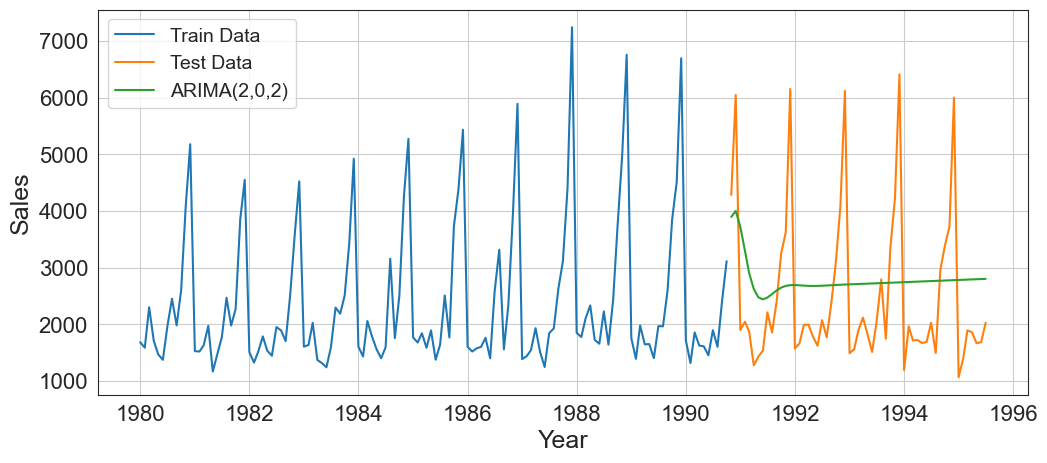

In [315]:
plt.figure(figsize=(12,5))
plt.plot(train['Sales'], label='Train Data')
plt.plot(test['Sales'], label='Test Data')
plt.plot(predicted_original_values, label='ARIMA(2,0,2)')
plt.xlabel('Year', fontsize=18, fontweight='medium')
plt.ylabel('Sales', fontsize=18, fontweight='medium')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(loc='best', fontsize=14)
plt.grid();

## SARIMA Model

### Selecting Parameters based on AIC

In [218]:
p = q = range(0,3)
d = range(0,2)
D = range(0,1)
pdq = list(itertools.product(p,d,q))
model_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p,D,q))]

In [219]:
pdq

[(0, 0, 0),
 (0, 0, 1),
 (0, 0, 2),
 (0, 1, 0),
 (0, 1, 1),
 (0, 1, 2),
 (1, 0, 0),
 (1, 0, 1),
 (1, 0, 2),
 (1, 1, 0),
 (1, 1, 1),
 (1, 1, 2),
 (2, 0, 0),
 (2, 0, 1),
 (2, 0, 2),
 (2, 1, 0),
 (2, 1, 1),
 (2, 1, 2)]

In [220]:
model_pdq

[(0, 0, 0, 12),
 (0, 0, 1, 12),
 (0, 0, 2, 12),
 (1, 0, 0, 12),
 (1, 0, 1, 12),
 (1, 0, 2, 12),
 (2, 0, 0, 12),
 (2, 0, 1, 12),
 (2, 0, 2, 12)]

In [221]:
sarima_aic_list = []

In [ ]:
for param in pdq:
    for param_seasonal in model_pdq:
        SARIMA_model = SARIMAX(train_Sales_diff, order=param, seasonal_order=param_seasonal,
                               enforce_stationarity=False, enforce_invertibility=False)
        results_SARIMA = SARIMA_model.fit(maxiter=1000)
        sarima_aic_list.append({'param':param, 'param_seasonal':param_seasonal, 'AIC': results_SARIMA.aic})

In [223]:
SARIMA_AIC = pd.DataFrame(sarima_aic_list)

In [317]:
SARIMA_AIC.sort_values(by='AIC').round(2)

,param,param_seasonal,AIC
50,"(0, 1, 2)","(1, 0, 2, 12)",1518.30
53,"(0, 1, 2)","(2, 0, 2, 12)",1518.54
158,"(2, 1, 2)","(1, 0, 2, 12)",1520.03
104,"(1, 1, 2)","(1, 0, 2, 12)",1520.21
107,"(1, 1, 2)","(2, 0, 2, 12)",1520.31
...,...,...,...
54,"(1, 0, 0)","(0, 0, 0, 12)",2214.85
0,"(0, 0, 0)","(0, 0, 0, 12)",2216.42
135,"(2, 1, 0)","(0, 0, 0, 12)",2240.11
81,"(1, 1, 0)","(0, 0, 0, 12)",2277.31


### Generating Model with Selected Parameters

In [225]:
mod = SARIMAX(train_Sales_diff, order=(0,1,2), seasonal_order=(1,0,2,12),
              enforce_invertibility=False, enforce_stationarity=False)

In [226]:
results_SARIMA_chosen = mod.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.67041D+00    |proj g|=  3.82833D-01

At iterate    5    f=  6.54284D+00    |proj g|=  1.41265D-02


 This problem is unconstrained.



At iterate   10    f=  6.53495D+00    |proj g|=  1.38455D-02

At iterate   15    f=  6.53448D+00    |proj g|=  1.85178D-03

At iterate   20    f=  6.53445D+00    |proj g|=  5.64966D-03

At iterate   25    f=  6.53130D+00    |proj g|=  6.20822D-02

At iterate   30    f=  6.49941D+00    |proj g|=  6.60316D-02

At iterate   35    f=  6.32487D+00    |proj g|=  1.61807D-01

At iterate   40    f=  6.04138D+00    |proj g|=  4.01506D-01

At iterate   45    f=  5.88849D+00    |proj g|=  8.66345D-01

At iterate   50    f=  5.83866D+00    |proj g|=  1.67222D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     69   

In [227]:
print(results_SARIMA_chosen.summary())

                                     SARIMAX Results                                      
Dep. Variable:                              Sales   No. Observations:                  129
Model:             SARIMAX(0, 1, 2)x(1, 0, 2, 12)   Log Likelihood                -753.187
Date:                            Tue, 09 Jul 2024   AIC                           1518.374
Time:                                    19:38:40   BIC                           1534.065
Sample:                                02-01-1980   HQIC                          1524.726
                                     - 10-01-1990                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.8932      0.054    -35.172      0.000      -1.999      -1.788
ma.L2          0.8985      0.050   

### Evaluation and Plotting Results

In [318]:
pred_SARIMA = results_SARIMA_chosen.forecast(steps=len(test))

#### Converting back from Differenced Values

In [319]:
pred_orig_val_SARIMA = last_original_value + pred_SARIMA.cumsum()

In [320]:
RMSE_SARIMA = np.sqrt(metrics.mean_squared_error(test['Sales'], pred_orig_val_SARIMA))

In [321]:
print(f'RMSE for SARIMA(0,1,2)(2,0,2,12) is {RMSE_SARIMA:0.2f}')

RMSE for SARIMA(0,1,2)(2,0,2,12) is 961.27


In [322]:
temp_results = pd.DataFrame({'Model': 'SARIMA(0,1,2)(1,0,2,12)', 'Test RMSE': RMSE_SARIMA}, index=[0])

In [323]:
resultsDF = pd.concat([resultsDF, temp_results], ignore_index=True)

In [326]:
resultsDF.round(2)

,Model,Test RMSE
0,Linear Regression,1392.44
1,2 point MA,1389.31
2,6 point MA,1443.15
3,9 point MA,1494.81
4,Auto SES Alpha 0.037,1362.43
5,SES Refined Alpha 0.4,1363.04
6,DES Refined Alpha 0.4 Beta 0.1,1369.14
7,"TES Auto A=0.075, B=0.032, C=0.479",366.86
8,TES Refined Alpha 0.1 Beta 0.9 Gamma 0.5,353.28
9,"ARIMA(2,0,2)",1340.63


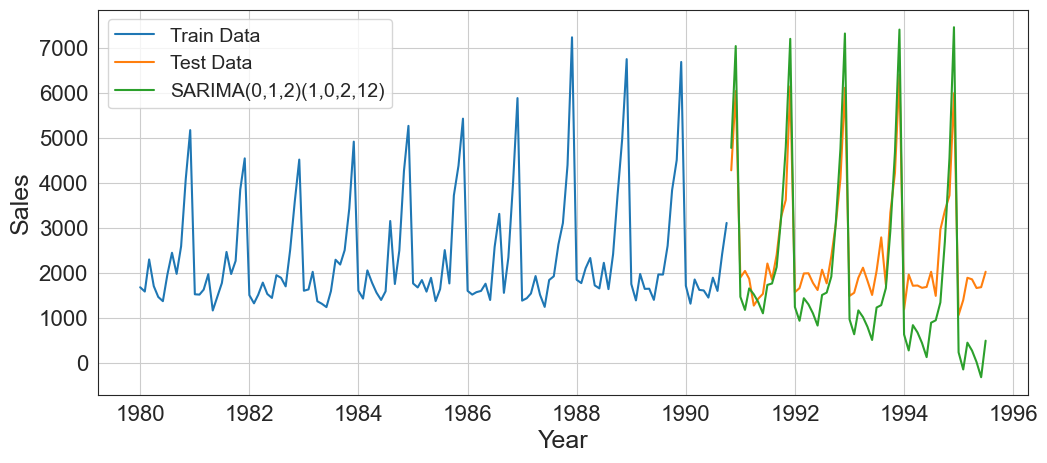

In [328]:
plt.figure(figsize=(12,5))
plt.plot(train['Sales'], label='Train Data')
plt.plot(test['Sales'], label='Test Data')
plt.plot(pred_orig_val_SARIMA, label='SARIMA(0,1,2)(1,0,2,12)')
plt.xlabel('Year', fontsize=18, fontweight='medium')
plt.ylabel('Sales', fontsize=18, fontweight='medium')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(loc='best', fontsize=14)
plt.grid();

### Making d=0 and Generating Another Model

In [236]:
mod1 = SARIMAX(train_Sales_diff, order=(0,0,2), seasonal_order=(1,0,2,12),
              enforce_invertibility=False, enforce_stationarity=False)

In [ ]:
results_SARIMA_chosen1 = mod1.fit()

In [330]:
print(results_SARIMA_chosen1.summary())

                                     SARIMAX Results                                      
Dep. Variable:                              Sales   No. Observations:                  129
Model:             SARIMAX(0, 0, 2)x(1, 0, 2, 12)   Log Likelihood                -756.361
Date:                            Wed, 10 Jul 2024   AIC                           1524.721
Time:                                    13:50:38   BIC                           1540.471
Sample:                                02-01-1980   HQIC                          1531.099
                                     - 10-01-1990                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8378      0.099     -8.451      0.000      -1.032      -0.644
ma.L2         -0.1105      0.116   

In [238]:
pred_SARIMA1 = results_SARIMA_chosen1.forecast(steps=len(test))

In [239]:
pred_orig_SARIMA_002 = last_original_value + pred_SARIMA1.cumsum()

In [240]:
RMSE_SARIMA1 = np.sqrt(metrics.mean_squared_error(test['Sales'], pred_orig_SARIMA_002))

In [241]:
print(f'RMSE for SARIMA(0,0,2)(1,0,2,12) is {RMSE_SARIMA1:0.2f}')

RMSE for SARIMA(0,0,2)(1,0,2,12) is 708.86


In [331]:
temp_results = pd.DataFrame({'Model': 'SARIMA(0,0,2)(1,0,2,12)', 'Test RMSE': RMSE_SARIMA1}, index=[0])

In [332]:
resultsDF = pd.concat([resultsDF, temp_results], ignore_index=True)

In [333]:
resultsDF.round(2)

,Model,Test RMSE
0,Linear Regression,1392.44
1,2 point MA,1389.31
2,6 point MA,1443.15
3,9 point MA,1494.81
4,Auto SES Alpha 0.037,1362.43
5,SES Refined Alpha 0.4,1363.04
6,DES Refined Alpha 0.4 Beta 0.1,1369.14
7,"TES Auto A=0.075, B=0.032, C=0.479",366.86
8,TES Refined Alpha 0.1 Beta 0.9 Gamma 0.5,353.28
9,"ARIMA(2,0,2)",1340.63


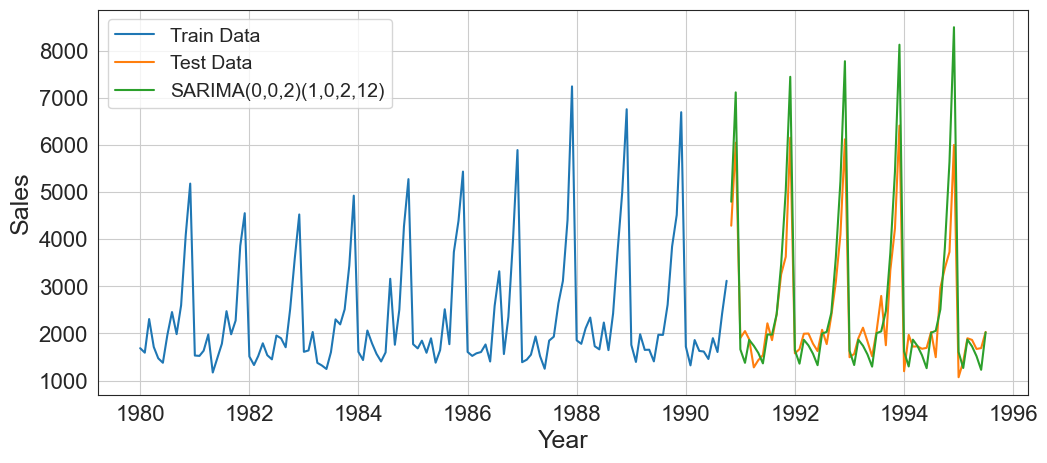

In [334]:
plt.figure(figsize=(12,5))
plt.plot(train['Sales'], label='Train Data')
plt.plot(test['Sales'], label='Test Data')
plt.plot(pred_orig_SARIMA_002, label='SARIMA(0,0,2)(1,0,2,12)')
plt.xlabel('Year', fontsize=18, fontweight='medium')
plt.ylabel('Sales', fontsize=18, fontweight='medium')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(loc='best', fontsize=14)
plt.grid();

# Final Model Selection & Forecasting

## Sorting Results by RMSE

In [337]:
resultsDF.sort_values(by='Test RMSE').round(1)

,Model,Test RMSE
8,TES Refined Alpha 0.1 Beta 0.9 Gamma 0.5,353.3
7,"TES Auto A=0.075, B=0.032, C=0.479",366.9
11,"SARIMA(0,0,2)(1,0,2,12)",708.9
10,"SARIMA(0,1,2)(1,0,2,12)",961.3
9,"ARIMA(2,0,2)",1340.6
4,Auto SES Alpha 0.037,1362.4
5,SES Refined Alpha 0.4,1363.0
6,DES Refined Alpha 0.4 Beta 0.1,1369.1
1,2 point MA,1389.3
0,Linear Regression,1392.4


## Final Model Selected as TES Refined Alpha 0.1 Beta 0.9 Gamma 0.5

In [247]:
TES_full = ExponentialSmoothing(df['Sales'], trend='add', seasonal='add', seasonal_periods=12)

In [248]:
model_TES_full = TES_full.fit(smoothing_level=0.1, smoothing_trend=0.9, smoothing_seasonal=0.5, optimized=False, use_brute=True)

In [249]:
forecast = model_TES_full.forecast(steps=24)

In [250]:
forecast_index = pd.date_range(start='1995-08-01', periods=24, freq='MS')

In [251]:
forecast_df = pd.DataFrame(forecast, index=forecast_index, columns=['Forecast'])

In [252]:
alpha = 0.05
z = 1.96
se = np.std(model_TES_full.resid)

In [253]:
conf_int_lower = forecast - z * se
conf_int_upper = forecast + z * se

In [254]:
conf_int_df = pd.DataFrame({'Lower': conf_int_lower, 'Upper': conf_int_upper}, index=forecast_index)

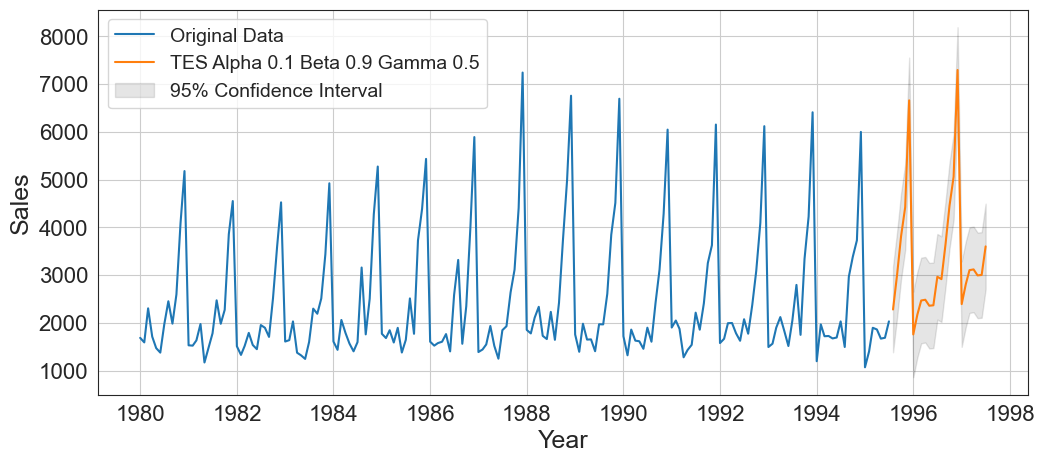

In [338]:
plt.figure(figsize=(12,5))
plt.plot(df['Sales'], label='Original Data')
plt.plot(forecast_df, label='TES Alpha 0.1 Beta 0.9 Gamma 0.5')
plt.fill_between(conf_int_df.index, conf_int_df['Lower'], conf_int_df['Upper'],
                 color='k', alpha=0.1, label='95% Confidence Interval')
plt.xlabel('Year', fontsize=18, fontweight='medium')
plt.ylabel('Sales', fontsize=18, fontweight='medium')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(loc='best', fontsize=14)
plt.grid();